# Recuento de esquistocitos
### Recuento

A partir de la carga del modelo de CNN creado desde cero, se hace el test con cada uno de los frotis obteniendo las matrices de confusión y las curvas ROC, y se calcula el recuento de esquistocitos en cada uno.

Lo primero es cargar las librerías y llamar a los directorios ya creados.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras import backend

import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [3]:
base_dir = 'RBC_recort_reesc'
dataset_resized = 'dataset_resized'

# Directories for the training, validation, and test
train_dir_2 = os.path.join(dataset_resized, 'train2')
validation_dir = os.path.join(dataset_resized, 'validation')
test_dir = os.path.join(dataset_resized, 'test')

# Directories with esquistocitos/no_esquistocitos pictures
train_esq_dir_2 = os.path.join(train_dir_2, '1_esquistocitos')
train_noesq_dir_2 = os.path.join(train_dir_2, '0_no_esquistocitos')

validation_esq_dir = os.path.join(validation_dir, '1_esquistocitos')
validation_noesq_dir = os.path.join(validation_dir, '0_no_esquistocitos')

test_esq_dir = os.path.join(test_dir, '1_esquistocitos')
test_noesq_dir = os.path.join(test_dir, '0_no_esquistocitos')

In [4]:
# Dimensiones de las imágenes de entrada
img_width, img_height = 220, 220

Se carga el modelo ya creado, y se compila de la misma manera para comprobar su evaluación. 

In [5]:
from keras.models import load_model
model = load_model('modelo.h5')

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 218, 218, 16)      448       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 109, 109, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 107, 107, 16)      2320      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 53, 53, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 51, 51, 16)        2320      
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 25, 25, 16)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 23, 23, 16)        2

In [7]:
# Compilación del modelo

model.compile(optimizer = tf.keras.optimizers.SGD(),
             loss = tf.keras.losses.BinaryCrossentropy(),
             metrics = ['accuracy'])

In [8]:
batch_size_train = 100
batch_size_val = 100

# Se reescalan todas las imágenes
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Imágenes de training de flujo en lotes(batches) de 100 usando el generador train_datagen
train_generator = train_datagen.flow_from_directory(train_dir_2,
                                                   batch_size = batch_size_train,
                                                   class_mode='binary',
                                                   target_size=(img_height, img_width))

# Imágenes de validación de flujo en lotes (batches) de 20? usando el generador test_datagen
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       batch_size=batch_size_val,
                                                       class_mode='binary',
                                                       target_size=(img_height, img_width))


Found 6000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [9]:
# Se cuenta el número de muestras de los tres conjuntos
muestras_train = len(os.listdir(train_esq_dir_2)+(os.listdir(train_noesq_dir_2)))
print (muestras_train)

muestras_validation = len(os.listdir(validation_esq_dir)+(os.listdir(validation_noesq_dir)))
print (muestras_validation)

muestras_test = len(os.listdir(test_esq_dir)+(os.listdir(test_noesq_dir)))
print (muestras_test)

6000
400
1400


In [10]:
# Evaluación del modelo para obtener la accuracy con el conjunto de test

batch_size = 1

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 batch_size=batch_size,
                                                 class_mode='binary',
                                                 target_size=(img_height, img_width),
                                                 shuffle=False)

evaluation = model.evaluate(test_generator,
                            steps=muestras_test,
                            verbose=1)

Found 1400 images belonging to 2 classes.
1400/1400 [==============================] - 6s 4ms/step - loss: 0.2782 - accuracy: 0.8936


La pérdida y la exactitud son las mismas, cosa que significa que el modelo se ha cargado correctamente.

A continuación se vuelven a crear las matrices de confusión con los dos umbrales y la curva ROC para poderlas observar en esta libreta.

In [11]:
predictions = model.predict(test_generator,
                            steps=muestras_test,
                            verbose=1)
#predictions

1400/1400 [==============================] - 5s 4ms/step


In [12]:
y_pred=[]
for i in predictions:
    if i < 0.5:
        i=0
        y_pred.append(i)
    else:
        i=1
        y_pred.append(i)
#y_pred

In [13]:
true_class = test_generator.classes
print (true_class)
class_labels = list(test_generator.class_indices.keys())
print (class_labels)

[0 0 0 ... 1 1 1]
['0_no_esquistocitos', '1_esquistocitos']


                    precision    recall  f1-score   support

0_no_esquistocitos     0.8573    0.9443    0.8987       700
   1_esquistocitos     0.9380    0.8429    0.8879       700

          accuracy                         0.8936      1400
         macro avg     0.8977    0.8936    0.8933      1400
      weighted avg     0.8977    0.8936    0.8933      1400



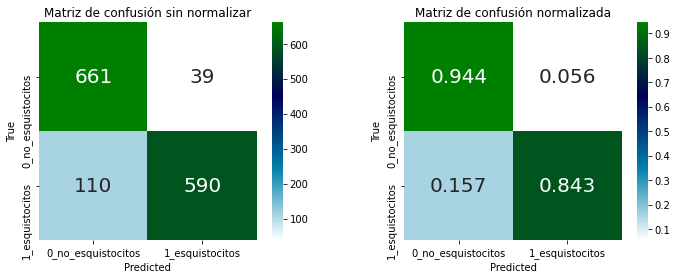

In [14]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score
import pandas as pd
import seaborn as sns

# Classification report
report = metrics.classification_report(true_class, y_pred, target_names=class_labels,digits=4)
print (report)

# Confusion matrix
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
cm = confusion_matrix(true_class, y_pred)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
cm_df

ax=sns.heatmap(cm_df, annot=True, fmt='2.0f', cmap='ocean_r',
               cbar=True, square=True, annot_kws={'fontsize':20})
ax.set_title('Matriz de confusión sin normalizar')

ax = fig.add_subplot(1,2,2)
cm = confusion_matrix(true_class, y_pred,normalize='true')
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
cm_df
ax=sns.heatmap(cm_df, annot=True, fmt='2.3f', cmap='ocean_r',
               cbar=True, square=True, annot_kws={'fontsize':20})
ax.set_title('Matriz de confusión normalizada')
#plt.savefig('cm_mejor_30e_las2umbral', dpi=300, bbox_inches='tight')
plt.show()

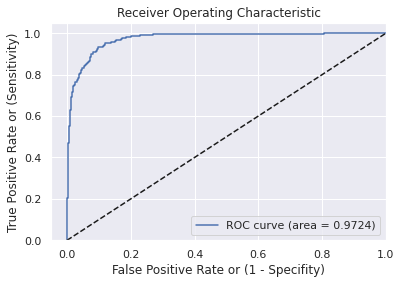

In [15]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_class, predictions, pos_label=1)
roc_auc = auc(fpr, tpr) #auc = area under curve

# Grafica ROC curve
sns.set(font_scale=1)
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('roc_mejor_30e', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
ix = np.argmax(tpr*(1-fpr))
ix_th = thresholds[ix]
print('Best Threshold=%f' % (ix_th))

Best Threshold=0.258959


In [17]:
y_pred=[]
for i in predictions:
    if i < ix_th:
        i=0
        y_pred.append(i)
    else:
        i=1
        y_pred.append(i)
#y_pred

In [18]:
true_class = test_generator.classes
print (true_class)
class_labels = list(test_generator.class_indices.keys())
print (class_labels)

[0 0 0 ... 1 1 1]
['0_no_esquistocitos', '1_esquistocitos']


                    precision    recall  f1-score   support

0_no_esquistocitos     0.9295    0.9043    0.9167       700
   1_esquistocitos     0.9068    0.9314    0.9190       700

          accuracy                         0.9179      1400
         macro avg     0.9182    0.9179    0.9178      1400
      weighted avg     0.9182    0.9179    0.9178      1400



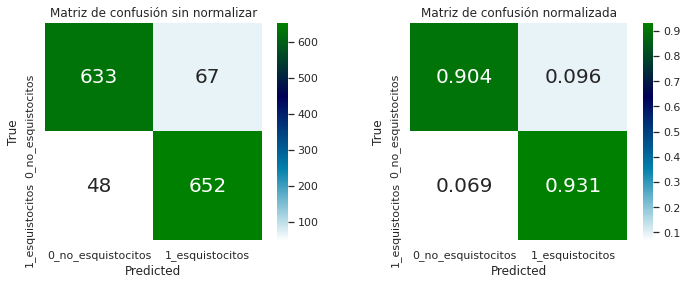

In [19]:
# Classification report
report = metrics.classification_report(true_class, y_pred, target_names=class_labels,digits=4)
print (report)

# Confusion matrix
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
cm = confusion_matrix(true_class, y_pred)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
cm_df

ax=sns.heatmap(cm_df, annot=True, fmt='2.0f', cmap='ocean_r',
               cbar=True, square=True, annot_kws={'fontsize':20})
ax.set_title('Matriz de confusión sin normalizar')

ax = fig.add_subplot(1,2,2)
cm = confusion_matrix(true_class, y_pred,normalize='true')
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
cm_df
ax=sns.heatmap(cm_df, annot=True, fmt='2.3f', cmap='ocean_r',
               cbar=True, square=True, annot_kws={'fontsize':20})
ax.set_title('Matriz de confusión normalizada')
#plt.savefig('cm_mejor_30e_las2umbral', dpi=300, bbox_inches='tight')
plt.show()

## TESTING POR FROTIS + RECUENTO

Se cargan las carpetas de los frotis y las que contienen esquistocitos y no esquistocitos.

In [20]:
base_dir = 'RBC_recort_reesc2'

esq_dir = os.path.join(base_dir, 'ESQUISTOS')
noesq_dir = os.path.join(base_dir, 'NORM')

frotis_dir = 'RBC_por_frotis'

frotis1dir = os.path.join(frotis_dir, 'frotis1')
frotis1dir_esq = os.path.join(frotis1dir, '1_esquistocitos')
frotis1dir_noesq = os.path.join(frotis1dir, '0_no_esquistocitos')

frotis2dir = os.path.join(frotis_dir, 'frotis2')
frotis2dir_esq = os.path.join(frotis2dir, '1_esquistocitos')
frotis2dir_noesq = os.path.join(frotis2dir, '0_no_esquistocitos')

frotis3dir = os.path.join(frotis_dir, 'frotis3')
frotis3dir_esq = os.path.join(frotis3dir, '1_esquistocitos')
frotis3dir_noesq = os.path.join(frotis3dir, '0_no_esquistocitos')

frotis4dir = os.path.join(frotis_dir, 'frotis4')
frotis4dir_esq = os.path.join(frotis4dir, '1_esquistocitos')
frotis4dir_noesq = os.path.join(frotis4dir, '0_no_esquistocitos')

frotis5dir = os.path.join(frotis_dir, 'frotis5')
frotis5dir_esq = os.path.join(frotis5dir, '1_esquistocitos')
frotis5dir_noesq = os.path.join(frotis5dir, '0_no_esquistocitos')

frotis6dir = os.path.join(frotis_dir, 'frotis6')
frotis6dir_esq = os.path.join(frotis6dir, '1_esquistocitos')
frotis6dir_noesq = os.path.join(frotis6dir, '0_no_esquistocitos')

frotis7dir = os.path.join(frotis_dir, 'frotis7')
frotis7dir_esq = os.path.join(frotis7dir, '1_esquistocitos')
frotis7dir_noesq = os.path.join(frotis7dir, '0_no_esquistocitos')

frotis8dir = os.path.join(frotis_dir, 'frotis8')
frotis8dir_esq = os.path.join(frotis8dir, '1_esquistocitos')
frotis8dir_noesq = os.path.join(frotis8dir, '0_no_esquistocitos')

frotis9dir = os.path.join(frotis_dir, 'frotis9')
frotis9dir_esq = os.path.join(frotis9dir, '1_esquistocitos')
frotis9dir_noesq = os.path.join(frotis9dir, '0_no_esquistocitos')

frotis10dir = os.path.join(frotis_dir, 'frotis10')
frotis10dir_esq = os.path.join(frotis10dir, '1_esquistocitos')
frotis10dir_noesq = os.path.join(frotis10dir, '0_no_esquistocitos')

frotis11dir = os.path.join(frotis_dir, 'frotis11')
frotis11dir_esq = os.path.join(frotis11dir, '1_esquistocitos')
frotis11dir_noesq = os.path.join(frotis11dir, '0_no_esquistocitos')

A continuación se crea una función evaluacion que realiza los mismos pasos hasta ahora pero con el objetivo de ser llamada para cada uno de los frotis. La función contiene las matrices de confusión con el umbral de 0.5 y el mejor umbral, en este caso de 0.26 aproximadamente, y las métricas (incluida la AUC de la curva ROC). También calcula el recuento de esquistocitos verdadero segun los parámetros de entrada, y el recuento de esquistocitos predicho por el modelo.

In [21]:
# Número para guardar las matrices de confusión y curvas roc con diferentes nombres
number = 1

# Función que contiene todos los pasos desde el testing hasta el recuento
def evaluacion (frotis_dir, muestras_esq, muestras_noesq):
    batch_size = 1
    test_generator = test_datagen.flow_from_directory(frotis_dir,
                                                 batch_size=batch_size,
                                                 class_mode='binary',
                                                 target_size=(img_height, img_width),
                                                 shuffle=False)
    
    muestras_frotis = muestras_esq + muestras_noesq
    
    evaluation = model.evaluate(test_generator,
                                steps=muestras_frotis,
                                verbose=1)
    
    predictions = model.predict(test_generator,
                                steps=muestras_frotis,
                                verbose=1)
    
    # UMBRAL 0.5
    
    y_pred=[]
    for i in predictions:
        if i < 0.5:
            i=0
            y_pred.append(i)
        else:
            i=1
            y_pred.append(i)
    
    true_class = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    
    # Classification report
    report = metrics.classification_report(true_class, y_pred, target_names=class_labels, digits=4)
    print (report)

    # Confusion matrix umbral
    cm = confusion_matrix(true_class, y_pred, normalize='true')
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm_df.index.name = 'True'
    cm_df.columns.name = 'Predicted'
    cm_df
    ax=sns.heatmap(cm_df, annot=True, fmt='2.3f', cmap='ocean_r',
                   cbar=True, square=True, annot_kws={'fontsize':20})
    
    global number
    ax.set_title('Matriz de confusión frotis {}, umbral 0.5'.format(number))
    #plt.savefig('{}cm_modelo_05'.format(number), dpi=300, bbox_inches='tight')
    plt.show()
    
    # F2 score
    precision = (cm_df['1_esquistocitos'][1]*muestras_esq) / ((cm_df['1_esquistocitos'][1]*muestras_esq) + (cm_df['1_esquistocitos'][0]*muestras_noesq))
    recall = (cm_df['1_esquistocitos'][1]*muestras_esq) / ((cm_df['1_esquistocitos'][1]*muestras_esq) + (cm_df['0_no_esquistocitos'][1]*muestras_esq))    
    F2score = (5*precision*recall)/((4*precision)+recall)
    print('F2socre = ', F2score)
    
    # Recuento de esquistocitos
    # Recuento(%)=(total de hamtíes reconocidos como esquistocitos)*100/(suma de no esquistocitos + esquistocitos)
    
    # 1. Recuento con las clases verdaderas
    recuento_verd = (muestras_esq / muestras_frotis) * 100
    print('Recuento = {} % de esquistocitos con las clases verdaderas'.format(recuento_verd))
    
    # 2. Recuento a partir del modelo
    FP = cm_df['1_esquistocitos'][0] # Falsos positivos (%): no esquistocitos reconocidos como esquistocitos
    VP = cm_df['1_esquistocitos'][1] # Verdaderos positivos (%): esquistocitos reconocidos como tal
    recuento_mod = (((FP*muestras_noesq)+(VP*muestras_esq)) / muestras_frotis) * 100
    print('Recuento = {} % de esquistocitos a partir del modelo'.format(recuento_mod))
    
    # 3. Diferencia de recuentos
    diferencia = recuento_mod - recuento_verd
    print ('Diferencia de recuentos = ', diferencia)
    
    
    # UMBRAL 0.26
    
    y_pred=[]
    for i in predictions:
        if i < ix_th:
            i=0
            y_pred.append(i)
        else:
            i=1
            y_pred.append(i)
    
    true_class = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    
    # Classification report
    report = metrics.classification_report(true_class, y_pred, target_names=class_labels, digits=4)
    print (report)

    # Confusion matrix umbral
    cm = confusion_matrix(true_class, y_pred, normalize='true')
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm_df.index.name = 'True'
    cm_df.columns.name = 'Predicted'
    cm_df
    ax=sns.heatmap(cm_df, annot=True, fmt='2.3f', cmap='ocean_r',
                   cbar=True, square=True, annot_kws={'fontsize':20})
    
    ax.set_title('Matriz de confusión frotis {}, umbral 0.26'.format(number))
    #plt.savefig('{}cm_modelo_029'.format(number), dpi=300, bbox_inches='tight')
    plt.show()
    
    # F2 score
    precision = (cm_df['1_esquistocitos'][1]*muestras_esq) / ((cm_df['1_esquistocitos'][1]*muestras_esq) + (cm_df['1_esquistocitos'][0]*muestras_noesq))
    recall = (cm_df['1_esquistocitos'][1]*muestras_esq) / ((cm_df['1_esquistocitos'][1]*muestras_esq) + (cm_df['0_no_esquistocitos'][1]*muestras_esq))    
    F2score = (5*precision*recall)/((4*precision)+recall)
    print('F2socre = ', F2score)
    
    # Recuento de esquistocitos
    # Recuento(%)=(total de hamtíes reconocidos como esquistocitos)*100/(suma de no esquistocitos + esquistocitos)
    
    # 1. Recuento con las clases verdaderas
    recuento_verd = (muestras_esq / muestras_frotis) * 100
    print('Recuento = {} % de esquistocitos con las clases verdaderas'.format(recuento_verd))
    
    # 2. Recuento a partir del modelo
    FP = cm_df['1_esquistocitos'][0] # Falsos positivos (%): no esquistocitos reconocidos como esquistocitos
    VP = cm_df['1_esquistocitos'][1] # Verdaderos positivos (%): esquistocitos reconocidos como tal
    recuento_mod = (((FP*muestras_noesq)+(VP*muestras_esq)) / muestras_frotis) * 100
    print('Recuento = {} % de esquistocitos a partir del modelo'.format(recuento_mod))
    
    # 3. Diferencia de recuentos
    diferencia = recuento_mod - recuento_verd
    print ('Diferencia de recuentos = ', diferencia)
    
    
    # CURVA ROC
    
    # calcula fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(true_class, predictions, pos_label=1)
    roc_auc = auc(fpr, tpr) #auc = area under curve

    # Grafica ROC curve
    sns.set(font_scale=1)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    #plt.savefig('{}roc_modelo'.format(number), dpi=300, bbox_inches='tight')
    plt.show()
    
    
    number += 1



Found 1729 images belonging to 2 classes.
1729/1729 [==============================] - 6s 4ms/step
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9854    0.9799    0.9826      1589
   1_esquistocitos     0.7852    0.8357    0.8097       140

          accuracy                         0.9682      1729
         macro avg     0.8853    0.9078    0.8962      1729
      weighted avg     0.9692    0.9682    0.9686      1729



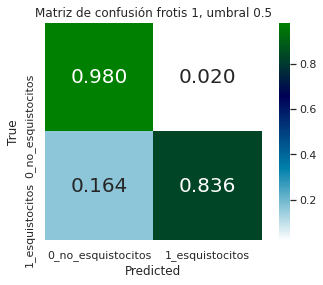

F2socre =  0.8251057827926658
Recuento = 8.097165991902834 % de esquistocitos con las clases verdaderas
Recuento = 8.617698091382302 % de esquistocitos a partir del modelo
Diferencia de recuentos =  0.5205320994794675
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9946    0.9358    0.9643      1589
   1_esquistocitos     0.5641    0.9429    0.7059       140

          accuracy                         0.9364      1729
         macro avg     0.7794    0.9393    0.8351      1729
      weighted avg     0.9598    0.9364    0.9434      1729



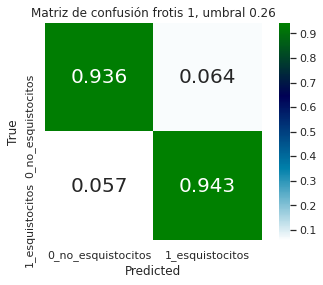

F2socre =  0.8312342569269521
Recuento = 8.097165991902834 % de esquistocitos con las clases verdaderas
Recuento = 13.533834586466165 % de esquistocitos a partir del modelo
Diferencia de recuentos =  5.436668594563331


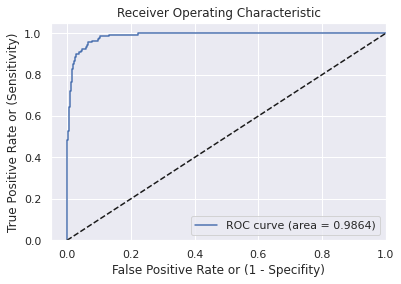

In [22]:
muestras_esq_frotis1 = len(os.listdir(frotis1dir_esq))
muestras_noesq_frotis1 = len(os.listdir(frotis1dir_noesq))

resultados_frotis1 = evaluacion(frotis1dir, muestras_esq_frotis1, muestras_noesq_frotis1)

Found 866 images belonging to 2 classes.
866/866 [==============================] - 3s 4ms/step
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9690    0.9399    0.9542       765
   1_esquistocitos     0.6290    0.7723    0.6933       101

          accuracy                         0.9203       866
         macro avg     0.7990    0.8561    0.8238       866
      weighted avg     0.9294    0.9203    0.9238       866



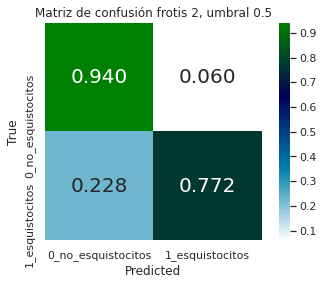

F2socre =  0.7386363636363635
Recuento = 11.662817551963048 % de esquistocitos con las clases verdaderas
Recuento = 14.318706697459586 % de esquistocitos a partir del modelo
Diferencia de recuentos =  2.6558891454965377
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9850    0.8575    0.9168       765
   1_esquistocitos     0.4550    0.9010    0.6047       101

          accuracy                         0.8626       866
         macro avg     0.7200    0.8793    0.7607       866
      weighted avg     0.9232    0.8626    0.8804       866



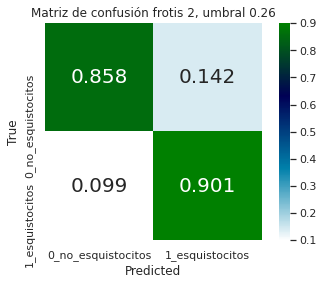

F2socre =  0.7533112582781456
Recuento = 11.662817551963048 % de esquistocitos con las clases verdaderas
Recuento = 23.094688221709006 % de esquistocitos a partir del modelo
Diferencia de recuentos =  11.431870669745958


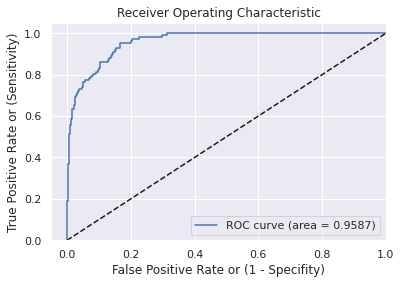

In [23]:
muestras_esq_frotis2 = len(os.listdir(frotis2dir_esq))
muestras_noesq_frotis2 = len(os.listdir(frotis2dir_noesq))

resultados_frotis2 = evaluacion(frotis2dir, muestras_esq_frotis2, muestras_noesq_frotis2)

Found 451 images belonging to 2 classes.
451/451 [==============================] - 2s 4ms/step
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9928    0.9811    0.9869       423
   1_esquistocitos     0.7576    0.8929    0.8197        28

          accuracy                         0.9756       451
         macro avg     0.8752    0.9370    0.9033       451
      weighted avg     0.9782    0.9756    0.9765       451



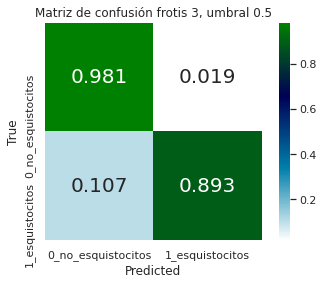

F2socre =  0.8620689655172414
Recuento = 6.208425720620843 % de esquistocitos con las clases verdaderas
Recuento = 7.317073170731707 % de esquistocitos a partir del modelo
Diferencia de recuentos =  1.1086474501108636
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9975    0.9480    0.9721       423
   1_esquistocitos     0.5510    0.9643    0.7013        28

          accuracy                         0.9490       451
         macro avg     0.7743    0.9561    0.8367       451
      weighted avg     0.9698    0.9490    0.9553       451



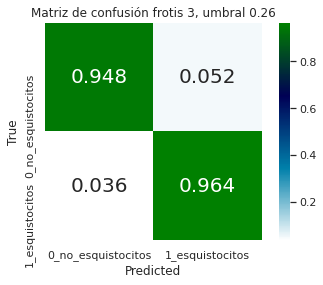

F2socre =  0.8385093167701864
Recuento = 6.208425720620843 % de esquistocitos con las clases verdaderas
Recuento = 10.864745011086473 % de esquistocitos a partir del modelo
Diferencia de recuentos =  4.65631929046563


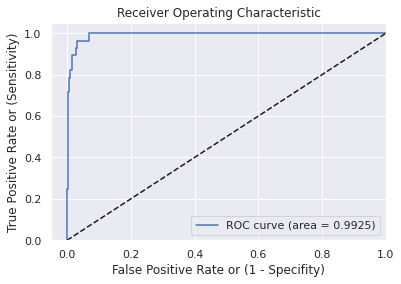

In [24]:
muestras_esq_frotis3 = len(os.listdir(frotis3dir_esq))
muestras_noesq_frotis3 = len(os.listdir(frotis3dir_noesq))

resultados_frotis3 = evaluacion(frotis3dir, muestras_esq_frotis3, muestras_noesq_frotis3)

Found 1471 images belonging to 2 classes.
1471/1471 [==============================] - 5s 4ms/step
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9510    0.9606    0.9558      1091
   1_esquistocitos     0.8835    0.8579    0.8705       380

          accuracy                         0.9341      1471
         macro avg     0.9172    0.9092    0.9131      1471
      weighted avg     0.9336    0.9341    0.9337      1471



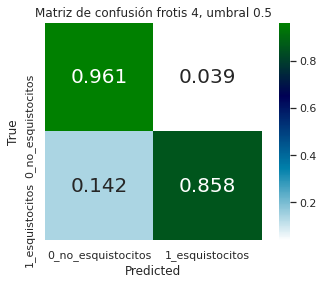

F2socre =  0.8628904182106936
Recuento = 25.832766825288918 % de esquistocitos con las clases verdaderas
Recuento = 25.084976206662134 % de esquistocitos a partir del modelo
Diferencia de recuentos =  -0.7477906186267838
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9755    0.9138    0.9437      1091
   1_esquistocitos     0.7906    0.9342    0.8565       380

          accuracy                         0.9191      1471
         macro avg     0.8831    0.9240    0.9001      1471
      weighted avg     0.9278    0.9191    0.9211      1471



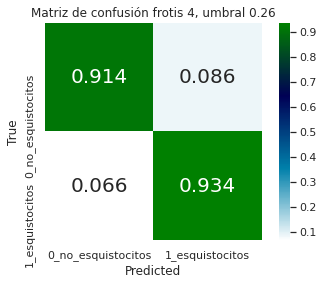

F2socre =  0.9014728288471305
Recuento = 25.832766825288918 % de esquistocitos con las clases verdaderas
Recuento = 30.52345343303875 % de esquistocitos a partir del modelo
Diferencia de recuentos =  4.690686607749832


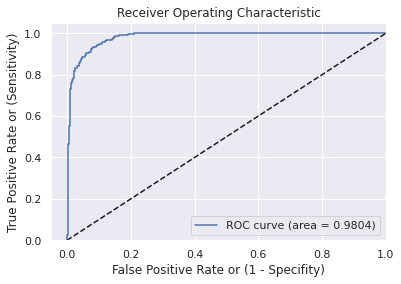

In [25]:
muestras_esq_frotis4 = len(os.listdir(frotis4dir_esq))
muestras_noesq_frotis4 = len(os.listdir(frotis4dir_noesq))

resultados_frotis4 = evaluacion(frotis4dir, muestras_esq_frotis4, muestras_noesq_frotis4)

Found 1070 images belonging to 2 classes.
1070/1070 [==============================] - 4s 4ms/step
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9632    0.9620    0.9626       789
   1_esquistocitos     0.8936    0.8968    0.8952       281

          accuracy                         0.9449      1070
         macro avg     0.9284    0.9294    0.9289      1070
      weighted avg     0.9449    0.9449    0.9449      1070



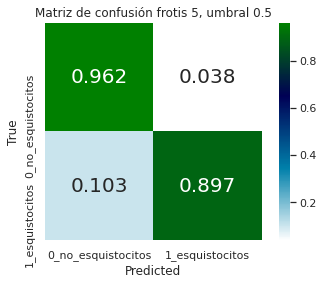

F2socre =  0.8961593172119486
Recuento = 26.261682242990652 % de esquistocitos con las clases verdaderas
Recuento = 26.355140186915886 % de esquistocitos a partir del modelo
Diferencia de recuentos =  0.09345794392523388
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9799    0.9265    0.9524       789
   1_esquistocitos     0.8210    0.9466    0.8793       281

          accuracy                         0.9318      1070
         macro avg     0.9004    0.9366    0.9159      1070
      weighted avg     0.9382    0.9318    0.9332      1070



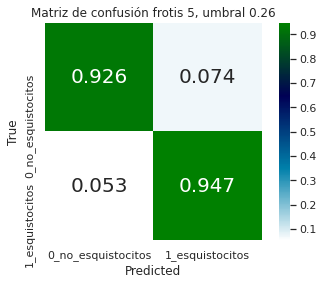

F2socre =  0.9185082872928175
Recuento = 26.261682242990652 % de esquistocitos con las clases verdaderas
Recuento = 30.2803738317757 % de esquistocitos a partir del modelo
Diferencia de recuentos =  4.01869158878505


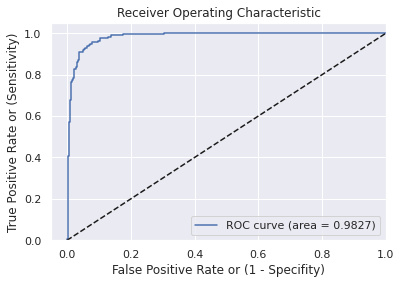

In [26]:
muestras_esq_frotis5 = len(os.listdir(frotis5dir_esq))
muestras_noesq_frotis5 = len(os.listdir(frotis5dir_noesq))

resultados_frotis5 = evaluacion(frotis5dir, muestras_esq_frotis5, muestras_noesq_frotis5)

Found 1053 images belonging to 2 classes.
1053/1053 [==============================] - 4s 4ms/step
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9573    0.9562    0.9568       845
   1_esquistocitos     0.8230    0.8269    0.8249       208

          accuracy                         0.9307      1053
         macro avg     0.8902    0.8916    0.8909      1053
      weighted avg     0.9308    0.9307    0.9307      1053



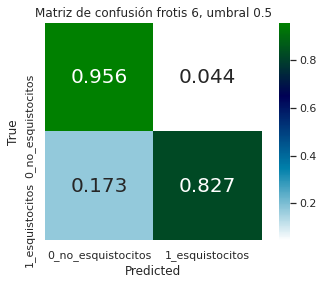

F2socre =  0.8261287223823245
Recuento = 19.753086419753085 % de esquistocitos con las clases verdaderas
Recuento = 19.848053181386515 % de esquistocitos a partir del modelo
Diferencia de recuentos =  0.09496676163342954
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9764    0.9302    0.9527       845
   1_esquistocitos     0.7621    0.9087    0.8289       208

          accuracy                         0.9259      1053
         macro avg     0.8692    0.9194    0.8908      1053
      weighted avg     0.9341    0.9259    0.9283      1053



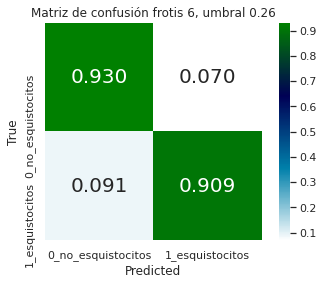

F2socre =  0.875
Recuento = 19.753086419753085 % de esquistocitos con las clases verdaderas
Recuento = 23.55175688509022 % de esquistocitos a partir del modelo
Diferencia de recuentos =  3.7986704653371355


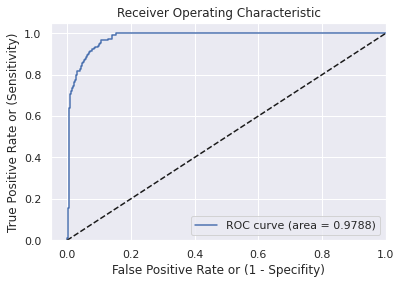

In [27]:
muestras_esq_frotis6 = len(os.listdir(frotis6dir_esq))
muestras_noesq_frotis6 = len(os.listdir(frotis6dir_noesq))

resultados_frotis6 = evaluacion(frotis6dir, muestras_esq_frotis6, muestras_noesq_frotis6)

Found 1524 images belonging to 2 classes.
1524/1524 [==============================] - 5s 4ms/step
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9674    0.9262    0.9464      1315
   1_esquistocitos     0.6340    0.8038    0.7089       209

          accuracy                         0.9094      1524
         macro avg     0.8007    0.8650    0.8276      1524
      weighted avg     0.9217    0.9094    0.9138      1524



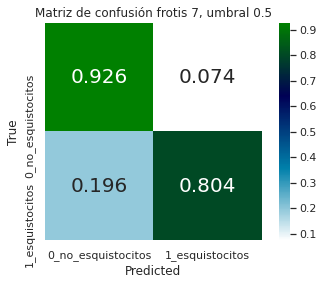

F2socre =  0.7629427792915531
Recuento = 13.713910761154855 % de esquistocitos con las clases verdaderas
Recuento = 17.38845144356955 % de esquistocitos a partir del modelo
Diferencia de recuentos =  3.674540682414696
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9855    0.8760    0.9275      1315
   1_esquistocitos     0.5408    0.9187    0.6809       209

          accuracy                         0.8819      1524
         macro avg     0.7632    0.8974    0.8042      1524
      weighted avg     0.9245    0.8819    0.8937      1524



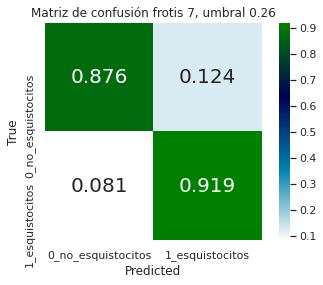

F2socre =  0.8060453400503779
Recuento = 13.713910761154855 % de esquistocitos con las clases verdaderas
Recuento = 23.293963254593177 % de esquistocitos a partir del modelo
Diferencia de recuentos =  9.580052493438322


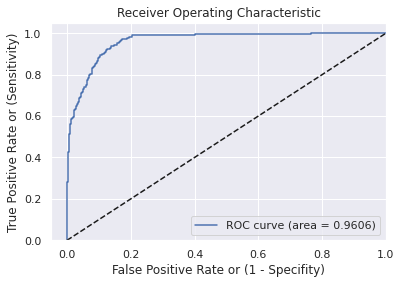

In [28]:
muestras_esq_frotis7 = len(os.listdir(frotis7dir_esq))
muestras_noesq_frotis7 = len(os.listdir(frotis7dir_noesq))

resultados_frotis7 = evaluacion(frotis7dir, muestras_esq_frotis7, muestras_noesq_frotis7)

Found 800 images belonging to 2 classes.
800/800 [==============================] - 3s 4ms/step
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9815    0.9505    0.9658       727
   1_esquistocitos     0.6250    0.8219    0.7101        73

          accuracy                         0.9387       800
         macro avg     0.8033    0.8862    0.8379       800
      weighted avg     0.9490    0.9387    0.9424       800



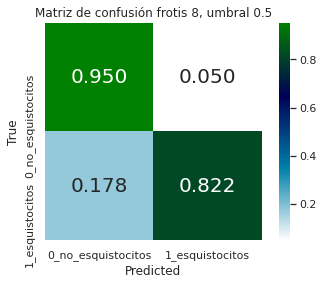

F2socre =  0.7731958762886598
Recuento = 9.125 % de esquistocitos con las clases verdaderas
Recuento = 12.0 % de esquistocitos a partir del modelo
Diferencia de recuentos =  2.875
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9881    0.9133    0.9492       727
   1_esquistocitos     0.5078    0.8904    0.6468        73

          accuracy                         0.9113       800
         macro avg     0.7480    0.9019    0.7980       800
      weighted avg     0.9443    0.9113    0.9216       800



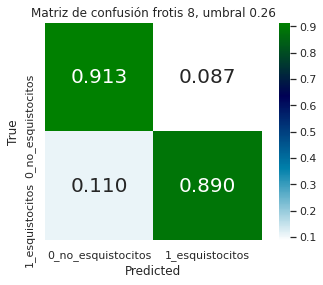

F2socre =  0.7738095238095237
Recuento = 9.125 % de esquistocitos con las clases verdaderas
Recuento = 16.0 % de esquistocitos a partir del modelo
Diferencia de recuentos =  6.875


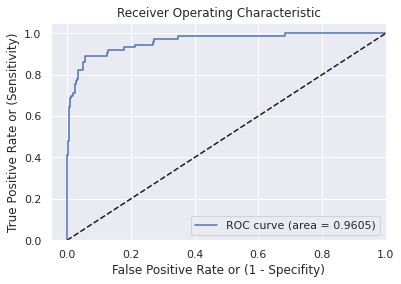

In [29]:
muestras_esq_frotis8 = len(os.listdir(frotis8dir_esq))
muestras_noesq_frotis8 = len(os.listdir(frotis8dir_noesq))

resultados_frotis8 = evaluacion(frotis8dir, muestras_esq_frotis8, muestras_noesq_frotis8)

Found 602 images belonging to 2 classes.
602/602 [==============================] - 2s 4ms/step
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9582    0.9413    0.9497       511
   1_esquistocitos     0.7000    0.7692    0.7330        91

          accuracy                         0.9153       602
         macro avg     0.8291    0.8553    0.8413       602
      weighted avg     0.9191    0.9153    0.9169       602



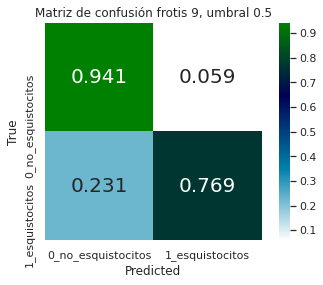

F2socre =  0.7543103448275863
Recuento = 15.11627906976744 % de esquistocitos con las clases verdaderas
Recuento = 16.611295681063122 % de esquistocitos a partir del modelo
Diferencia de recuentos =  1.4950166112956822
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9762    0.8845    0.9281       511
   1_esquistocitos     0.5755    0.8791    0.6957        91

          accuracy                         0.8837       602
         macro avg     0.7759    0.8818    0.8119       602
      weighted avg     0.9157    0.8837    0.8930       602



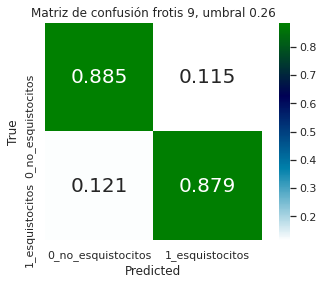

F2socre =  0.7952286282306162
Recuento = 15.11627906976744 % de esquistocitos con las clases verdaderas
Recuento = 23.089700996677742 % de esquistocitos a partir del modelo
Diferencia de recuentos =  7.9734219269103015


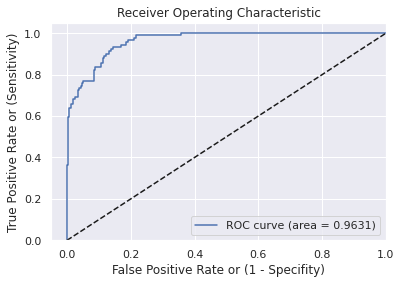

In [30]:
muestras_esq_frotis9 = len(os.listdir(frotis9dir_esq))
muestras_noesq_frotis9 = len(os.listdir(frotis9dir_noesq))

resultados_frotis9 = evaluacion(frotis9dir, muestras_esq_frotis9, muestras_noesq_frotis9)

Found 1253 images belonging to 2 classes.
1253/1253 [==============================] - 4s 4ms/step
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9759    0.9477    0.9616      1109
   1_esquistocitos     0.6705    0.8194    0.7375       144

          accuracy                         0.9330      1253
         macro avg     0.8232    0.8836    0.8495      1253
      weighted avg     0.9408    0.9330    0.9358      1253



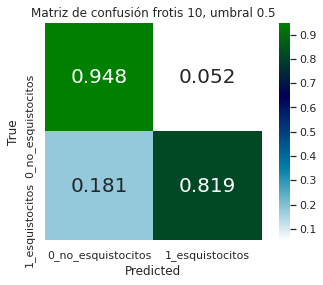

F2socre =  0.7845744680851063
Recuento = 11.49241819632881 % de esquistocitos con las clases verdaderas
Recuento = 14.046288906624103 % de esquistocitos a partir del modelo
Diferencia de recuentos =  2.5538707102952927
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9902    0.9143    0.9508      1109
   1_esquistocitos     0.5852    0.9306    0.7185       144

          accuracy                         0.9162      1253
         macro avg     0.7877    0.9224    0.8346      1253
      weighted avg     0.9437    0.9162    0.9241      1253



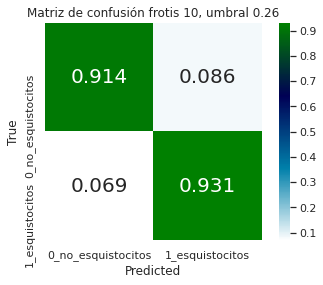

F2socre =  0.8322981366459627
Recuento = 11.49241819632881 % de esquistocitos con las clases verdaderas
Recuento = 18.27613727055068 % de esquistocitos a partir del modelo
Diferencia de recuentos =  6.783719074221871


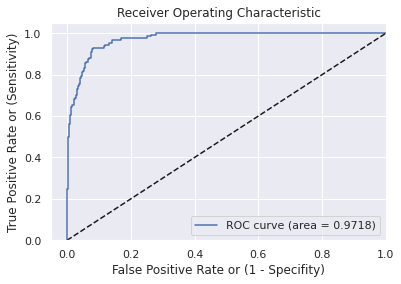

In [31]:
muestras_esq_frotis10 = len(os.listdir(frotis10dir_esq))
muestras_noesq_frotis10 = len(os.listdir(frotis10dir_noesq))

resultados_frotis10 = evaluacion(frotis10dir, muestras_esq_frotis10, muestras_noesq_frotis10)

Found 1037 images belonging to 2 classes.
1037/1037 [==============================] - 4s 4ms/step
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9920    0.9037    0.9458       955
   1_esquistocitos     0.4491    0.9146    0.6024        82

          accuracy                         0.9045      1037
         macro avg     0.7205    0.9091    0.7741      1037
      weighted avg     0.9490    0.9045    0.9186      1037



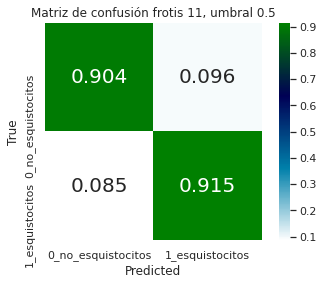

F2socre =  0.7575757575757577
Recuento = 7.907425265188042 % de esquistocitos con las clases verdaderas
Recuento = 16.104146576663453 % de esquistocitos a partir del modelo
Diferencia de recuentos =  8.196721311475411
                    precision    recall  f1-score   support

0_no_esquistocitos     0.9950    0.8314    0.9059       955
   1_esquistocitos     0.3264    0.9512    0.4860        82

          accuracy                         0.8409      1037
         macro avg     0.6607    0.8913    0.6959      1037
      weighted avg     0.9421    0.8409    0.8727      1037



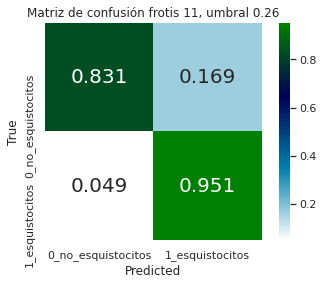

F2socre =  0.6878306878306878
Recuento = 7.907425265188042 % de esquistocitos con las clases verdaderas
Recuento = 23.04725168756027 % de esquistocitos a partir del modelo
Diferencia de recuentos =  15.139826422372227


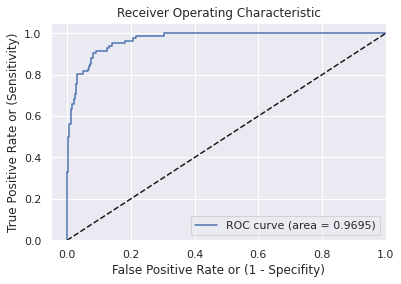

In [32]:
muestras_esq_frotis11 = len(os.listdir(frotis11dir_esq))
muestras_noesq_frotis11 = len(os.listdir(frotis11dir_noesq))

resultados_frotis11 = evaluacion(frotis11dir, muestras_esq_frotis11, muestras_noesq_frotis11)

Como se observa, algunas matrices de confusión son mejores con el umbral de 0.26. Sin embargo, con este umbral la diferencia de esquistocitos es mayor que con el umbral por defecto de 0.5, debido al desbalanceo de clases.